# Anomaly Detection

Anomaly detection describes the process of finding outliers, for some definition of what an outler is. Since the definition of outlier is quite context dependent, there are many anomaly deteciton methods. Anomaly deteciton is generally used in an unsupervised fashion, although we use labeled data for evaluatoin. 

This lecture does not focus on specific mehtods of anomaly detection. Instead, we focus on the general principles and pragmatic coding examples uisng `scikit-learn`. Topics covered:

- Use of PCA for anomaly detection
- Use of validation and test data sets
- Model evaluation and scoring
- ROC curve
- Precision recall curve
- Overfitting
- Example of embarassingly parallel code

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
from scipy.io import loadmat
from scipy.io.arff import loadarff

In [4]:
import numpy as np

In [5]:
import pandas as pd

In [6]:
from collections import OrderedDict

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, auc, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.externals.joblib import Parallel, delayed

In [8]:
import seaborn as sns
sns.set(font_scale=1.5)

## Information about data

The [Cardiotocogrpahy dataset](http://odds.cs.stonybrook.edu/cardiotocogrpahy-dataset/) has the following description (from the linked URL):

```
The original Cardiotocography (Cardio) dataset from UCI machine learning repository consists of measurements of fetal heart rate (FHR) and uterine contraction (UC) features on cardiotocograms classified by expert obstetricians. This is a classification dataset, where the classes are normal, suspect, and pathologic. For outlier detection, The normal class formed the inliers, while the pathologic (outlier) class is downsampled to 176 points. The suspect class is discarded.
```

We will try to detect outliers wihtout using any lables.

### Load data and inspect

In [9]:
data = loadmat('data/cardio.mat')

In [10]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [11]:
X = data['X']
y = data['y']

In [12]:
X.shape, y.shape

((1831, 21), (1831, 1))

In [13]:
y = y.squeeze()

### Scale data to have zero mean and unit standard deviation

In [14]:
scaler = StandardScaler()

In [15]:
X = scaler.fit_transform(X)

### Split into test and trainign data sets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=20198)

### Define score function

In [17]:
def score(a, b):
    """Normalized differnece of squares between a and b."""
    
    loss = np.sum((a-b)**2, axis=1)
    loss = (loss-loss.min())/(loss.max() - loss.min())
    return loss

### Concept of using PCA for outlier detection

We find the robust features of the data set using PCA, expecting these to be mostly contributed by the more abundant inliers. In other words, we expect the inliers to be well summarized by the reduced dimensionality PCA data set, and the outliers to be less well summarized. Now we can reconstruct the original $n$-dimensional space from the $k$-dimensional reduced space, and compare the reconstructed data vectors with the original ones. If the reconstruction is good, we expect the distance between original and reconstructed vectors to be small, and big otherwise. Hence the normalized distance between original and reconstructed vectors might give some clue as to which data points are poorly captured by the reduced dimension PCA representation, and hence possible outliers.

In [18]:
def fit(n, X):
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X)
    X_pca_inverse = pca.inverse_transform(X_pca)
    y_score = score(X, X_pca_inverse)
    return (n, y_score)

### Find opitmal parameter (n) by grid search

In [19]:
search = Parallel(n_jobs=-1)(delayed(fit)(n, X_train) for n in range(2,X.shape[1]))

In [20]:
scores =  np.array([(n, average_precision_score(y_train, y_score)) for (n, y_score) in search])

In [21]:
best = max(scores, key=lambda x: x[1])
best

array([2.        , 0.43654539])

### Visualize scores 

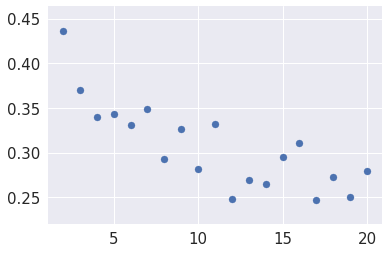

In [22]:
plt.scatter(scores[:, 0], scores[:, 1])
pass

## Precision-recall and ROC curves

### Confusion matrix

| | | Truth=P | Truth=N |
| - | - | - | 
| **Predict=P** | | TP | FP  |
| **Predict=N** | | FN | TN |


We will use these definitnios in the construciton of the preciison-recall and ROC curves.

### PRC (Precision-recall Curve)

- X axis is the recall 
$$
\frac{\text{TP}}{\text{TP + FN}}
$$
- Y axis is the preciison
$$
\frac{\text{TP}}{\text{TP + FP}}
$$

### ROC (Receiver Operating Characteristics)

- X axis is the False Positive Rate (FPR)
$$
\frac{\text{FP}}{\text{FP + TN}}
$$
- Y axis is the True Positive Rate (TPR)
$$
\frac{\text{TP}}{\text{TP + FN}}
$$

To plot the PRC and ROC, we calcualte the necessary statistics for a range of cutoff values or thresholds - for example, the cutoff may be whether the score is lower or higher than 0.2, or 0.3 etc.

### Imbalanced data sets

In real world settlings, imbalanced data sets, where members of one class are abundant while the other are infrequent, are common. Imbalanced data sets are nearly always due to the preponderance of true negatives (TN), for example, when screening natural compounds, nearly all will be expected to have no or minimal anti-cancer activity. 

Notice that TN is NOT used in the PRC, which is hence robust to data sets imbalanced becasue most of the data come from the TN class. In contrast, the use of the FPR makes the ROC sensitive to such data sets.

### Test on hold-out data

In [23]:
n = int(best[0])
n, y_score = fit(n, X_test)

In [24]:
average_precision_score(y_test, y_score)

0.4636398109078834

### Visualize scores for inliers and outliers

In [25]:
df = pd.DataFrame(dict(score=y_score, y=y_test))

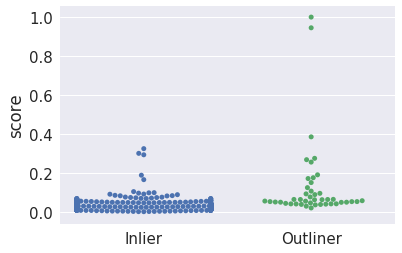

In [26]:
g = sns.swarmplot(data=df, x='y', y='score')
g.set_xticklabels(['Inlier', 'Outliner'])
g.set_xlabel('')
pass

### Evaluate model 

In [27]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
fpr, tpr, thresholds = roc_curve(y_test, y_score)

### Plot ROC curve

While this looks reasoably good, it is misleading because the data set is unbalanced. Why is ROC misleading when there is unbalanced data?

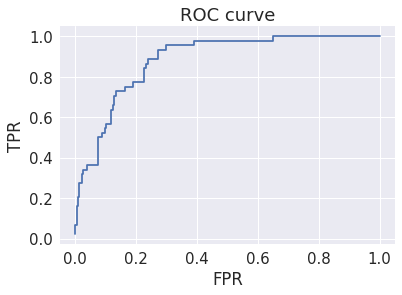

In [28]:
plt.step(fpr, tpr, where='post')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
pass

### Plot precision-recall curve

Precision-recall is more useful for evaluating models for unbalanced data sets. Why is precision-recall robust to unbalanced data?

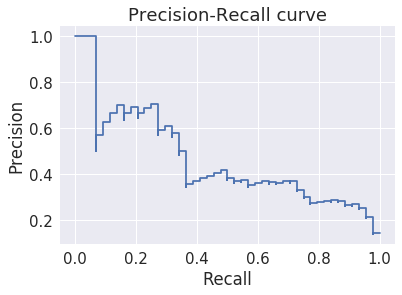

In [29]:
plt.step(recall, precision, where='post')
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
pass

## Case study

This illustrates danger of over-fitting.

### Dataset information

Please download the [Credit Card Fraud Detection data set](https://www.kaggle.com/samkirkiles/credit-card-fraud/data) and put it in the `data` folder. You will need to have a Kaggle account to do so.

In [30]:
df = pd.read_csv('data/creditcard.csv')

In [31]:
X = df.loc[:, df.columns.drop('Class')]
y = df.Class

In [32]:
y.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [33]:
X = scaler.fit_transform(X)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2018)

In [35]:
X_train.shape, y_train.shape

((213605, 30), (213605,))

In [36]:
search = Parallel(n_jobs=-1)(delayed(fit)(n, X_train) for n in range(2,X.shape[1]))

In [37]:
scores =  np.array([(n, average_precision_score(y_train, y_score)) for (n, y_score) in search])

### This is an amazingly good average precision score

In [38]:
best = max(scores, key=lambda x: x[1])
best

array([27.        ,  0.69112164])

In [39]:
n = int(best[0])
n, y_score = fit(n, X_train)

In [40]:
precision, recall, thresholds = precision_recall_curve(y_train, y_score)
fpr, tpr, thresholds = roc_curve(y_train, y_score)

### The precision-recall curve is also amazingly good

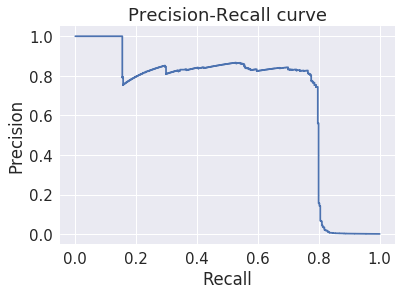

In [41]:
plt.step(recall, precision, where='post')
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
pass

### We remember that we should test on the hold-out set

In [42]:
n = int(best[0])
n, y_score = fit(n, X_test)

#### The results are markedly less impressive

In [43]:
average_precision_score(y_test, y_score)

0.006965112161324013

In [44]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
fpr, tpr, thresholds = roc_curve(y_test, y_score)

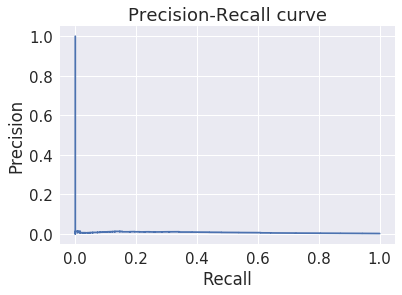

In [45]:
plt.step(recall, precision, where='post')
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
pass

### Why?

There are problay two reasons for the surprisingly bad perfromance.

- The first is taht the easy fraud cases, just by chance, ended up mostly in the trainign set
- Then grid-search found the a fortuitously effective value of $n$
- When we evaluate on the test set, this fails miserably because
    - The hard fraud cases are over-represented in the test cases
    - The value of $n$ is overfitted on the training data and does not generalize

### Let's check what happeens with a differnet random number seed

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2019)

In [47]:
X_train.shape, y_train.shape

((213605, 30), (213605,))

In [48]:
search = Parallel(n_jobs=-1)(delayed(fit)(n, X_train) for n in range(2,X.shape[1]))

In [49]:
scores =  np.array([(n, average_precision_score(y_train, y_score)) for (n, y_score) in search])

### The average precison score is much worse

This strongly suggests that the previous result was a fluke of the distribution of the easy and hard fraud cases.

In [50]:
best = max(scores, key=lambda x: x[1])
best

array([10.        ,  0.19941431])

In [51]:
n = int(best[0])
n, y_score = fit(n, X_train)

In [52]:
precision, recall, thresholds = precision_recall_curve(y_train, y_score)
fpr, tpr, thresholds = roc_curve(y_train, y_score)

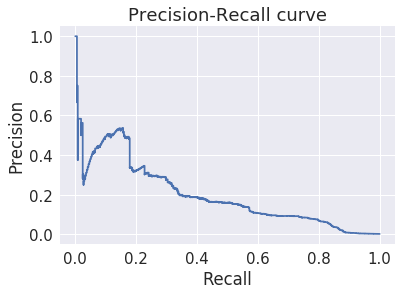

In [53]:
plt.step(recall, precision, where='post')
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
pass